In [373]:
CODE_PATH = "../trainer"

In [374]:
import sys
sys.path.append(CODE_PATH)

In [375]:
import os
from PIL import Image
import random

from tqdm.auto import tqdm

import torch
import torchvision as tv
from transformers import AutoTokenizer

from ignite.engine import (
    Engine,
    Events,
)
from ignite.handlers import Checkpoint
from ignite.contrib.handlers import global_step_from_engine
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.neptune_logger import NeptuneLogger

In [376]:
from ctc import GreedyDecoder
from igmetrics import ExactMatch

In [377]:
tokenizer = AutoTokenizer.from_pretrained(f"{CODE_PATH}/synth-tokenizers/tokenizer-pad0")
decoder = GreedyDecoder(tokenizer.pad_token_id)

# Dataset

In [378]:
class SynthDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotation_file, height=32):
        self.images_dir = images_dir
        self.annotation_file = annotation_file
        self.image_files = self._load_data()
        self.height = height

    def _load_data(self):
        with open(self.annotation_file, "r") as f:
            lines = f.read().splitlines()

        image_files = [line.split(" ")[0] for line in lines]
        return image_files
    
    def __len__(self):
        return len(self.image_files)
    
    def read_image_file_and_label(self, image_file):
        label = image_file.split("_")[1]
        image_path = os.path.join(self.images_dir, image_file)
        
        image = Image.open(image_path).convert("L")
        w, h = image.size
        ratio = w / float(h)
        nw = round(self.height * ratio)

        image = image.resize((nw, self.height), Image.BICUBIC)

        return image, label

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        
        try:
            image, label = self.read_image_file_and_label(image_file)
        except:
            print(f"Error reading image {image_file} idx {idx}")
            return self.__getitem__(random.randint(0, len(self.image_files) - 1))

        return image, label    
    

In [379]:
IMAGES_DIR = "../data/synth/mnt/90kDICT32px/"
TRAIN_ANNOTATION_FILE = "../data/synth/mnt/annotation_train_good.txt"
VAL_ANNOTATION_FILE = "../data/synth/mnt/annotation_val_good.txt"

In [380]:
train_dataset = SynthDataset(IMAGES_DIR, TRAIN_ANNOTATION_FILE)
val_dataset = SynthDataset(IMAGES_DIR, VAL_ANNOTATION_FILE)

# DataModule

In [381]:
from dataclasses import dataclass, field
from typing import Any

from torch.utils.data import DataLoader

In [382]:
class MaxPoolImagePad:
    def __init__(self):
        self.pool = torch.nn.Sequential(
            torch.nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
            torch.nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        )

    def __call__(self, x):
        return self.pool(x)

In [383]:
POOLER = MaxPoolImagePad()

In [384]:
@dataclass
class SynthDataModule:
    train_dataset: Any = field(metadata="Training dataset")
    val_dataset: Any = field(metadata="Validation dataset")
    tokenizer: Any = field(metadata="tokenizer")
    train_bs: int = field(default=16, metadata="Training batch size")
    valid_bs: int = field(default=16, metadata="Eval batch size")
    num_workers: int = field(default=2)
    max_width: int = field(default=None)

    @staticmethod
    def expand_image(img, h, w):
        expanded = Image.new("L", (w, h), color=(0,))  # black
        expanded.paste(img)
        return expanded

    def collate_fn(self, samples):
        images = [s[0] for s in samples]
        labels = [s[1] for s in samples]

        image_widths = [im.width for im in images]
        max_width = (
            self.max_width if self.max_width is not None else max(image_widths)
        )

        attention_images = []
        for w in image_widths:
            attention_images.append([1] * w + [0] * (max_width - w))
        attention_images = (
            POOLER(torch.tensor(attention_images).float()).long()
        )

        h = images[0].size[1]
        to_tensor = tv.transforms.ToTensor()
        images = [
            to_tensor(self.expand_image(im, h=h, w=max_width)) for im in images
        ]

        tokens = self.tokenizer.batch_encode_plus(
            labels, padding="longest", return_tensors="pt"
        )
        input_ids = tokens.get("input_ids")
        attention_mask = tokens.get("attention_mask")

        return torch.stack(images), input_ids, attention_mask, attention_images

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_bs,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.valid_bs,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

In [385]:
datamodule = SynthDataModule(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    train_bs=8,
    valid_bs=16,
    num_workers=4,
)

In [386]:
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

# Model

In [387]:
from torch import nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class Feature2Embedding(nn.Module):
    def forward(self, x):
        n, c, h, w = x.shape
        assert h == 1, "the height of out must be 1"
        x = x.squeeze(2) # [n, c, w]
        return x.permute(0, 2, 1) # [n, w, c]

class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, st=(2,1)):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels, momentum=0.01, eps=1e-3),
            Swish()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=st, padding=1),
            nn.BatchNorm2d(out_channels, momentum=0.01, eps=1e-3),
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=st, padding=0),
            nn.BatchNorm2d(out_channels, momentum=0.01, eps=1e-3),
        )

        self.swish = Swish()

    def forward(self, x):
        input = x
        x = self.conv1(x)
        x = self.conv2(x) + self.downsample(input)
        x = self.swish(x)
        return x

class ResNetLike(nn.Module):
    """
    Custom CNN
    """

    def __init__(
        self,
        vocab_size: int = 100,
        p: float = 0.0,
    ):
        super().__init__()

        self.image_embeddings = nn.Sequential(
            self.block(1, 64, st=(2, 2)),
            nn.Dropout2d(p),
            self.block(64, 128, st=(2, 2)),
            nn.Dropout2d(p),
            self.block(128, 256, st=(2, 1)),
            nn.Dropout2d(p),
            self.block(256, 512, st=(4, 1)),
            nn.Dropout2d(p),
            Feature2Embedding(),
        )
        self.lm_head = nn.Linear(512, vocab_size)

    def block(self, in_channels, out_channels, st=2):
        return ResidualBlock(in_channels=in_channels, out_channels=out_channels, st=st)
    
    def forward(self, images, *args, **kwargs):
        embedding = self.image_embeddings(images)
        logits = self.lm_head(embedding)
        return logits

    def lm(self, embedding):
        return self.lm_head(embedding)

In [499]:
model = ResNetLike(vocab_size=tokenizer.vocab_size, p=0.0)

# Ignite

In [500]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [501]:
_ = model.to(device)

In [502]:
# criterion = torch.nn.CTCLoss(blank=tokenizer.pad_token_id, zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)

In [503]:
def get_preds_from_logits(logits, attention_image, labels):
    decoded_ids = logits.argmax(-1).squeeze(0)
    if len(decoded_ids.shape) == 1:
        decoded_ids = decoded_ids.unsqueeze(0)
    
    decoded = [
        decoder(dec, att) for dec, att in zip(decoded_ids, attention_image)
    ]
    y_pred = tokenizer.batch_decode(decoded, skip_special_tokens=True)
    y = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return y_pred, y

In [504]:
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    images, labels, attention_mask, attention_image = [
        x.to(device) if x is not None else x for x in batch
    ]

    logits = model(images)

    input_length = attention_image.sum(-1)
    target_length = attention_mask.sum(-1)

    logits = logits.permute(1, 0, 2)
    logits = logits.log_softmax(2)

    criterion = torch.nn.CTCLoss(blank=tokenizer.pad_token_id, zero_infinity=True, reduction="none")
    loss = criterion(logits, labels, input_length, target_length)

    # check if loss is nan
    isnan_loss = torch.isnan(loss.mean()).item()
    if isnan_loss:
        print("Loss is NaN")
        sys.exit(1)
        return 0

    # check if loss is negative
    is_neg_loss = loss.min().item() < 0
    if is_neg_loss:
        print("Loss is negative, zeroing it")
        return 0
        zero_loss = (loss > 0) * 1
        loss  =  zero_loss * loss

    loss = loss.mean()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    return loss

In [505]:
def val_step(engine, batch):
    model.eval()
    images, labels, _, attention_image = [x.to(device) if x is not None else x for x in batch]
    with torch.no_grad():
        logits = model(images)

    y_pred, y = get_preds_from_logits(logits, attention_image, labels)
    return y_pred, y
    

In [506]:
checkpoint = torch.load("/home/israel/Mestrado/notebooks/synth-broken-ckpts/checkpoint_1220000.pt")
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [507]:
import numpy as np
import copy

In [508]:
PREVIOUS_BATCH = None
CURRENT_BATCH = None

In [509]:
# nan_losses = []
# for idx, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
#     CURRENT_BATCH = copy.deepcopy(batch)
#     loss = train_step(None, batch)
#     if torch.isnan(loss).item():
#         print("Adding nan loss", idx)
#         nan_losses.append(idx)
#         break

#     PREVIOUS_BATCH = copy.deepcopy(batch)

In [510]:
# torch.save(PREVIOUS_BATCH, "previous_batch.pt")
# torch.save(CURRENT_BATCH, "current_batch.pt")
PREVIOUS_BATCH = torch.load("previous_batch.pt")
CURRENT_BATCH = torch.load("current_batch.pt")

In [511]:
images, labels, attention_mask, attention_image = PREVIOUS_BATCH
images = images.to("cpu")

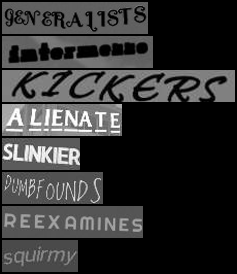

In [512]:
grid = tv.utils.make_grid(images, nrow=1)
tv.transforms.ToPILImage()(grid)

In [513]:
tokenizer.batch_decode(labels, skip_special_tokens=True)

['GENERALISTS',
 'intermezzo',
 'KICKERS',
 'ALIENATE',
 'SLINKIER',
 'DUMBFOUNDS',
 'REEXAMINES',
 'squirmy']

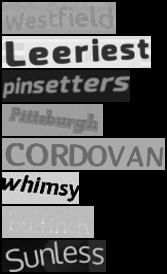

In [514]:
images, labels, attention_mask, attention_image = CURRENT_BATCH
images = images.to("cpu")

grid = tv.utils.make_grid(images, nrow=1)
tv.transforms.ToPILImage()(grid)

In [515]:
tokenizer.batch_decode(labels, skip_special_tokens=True)

['Westfield',
 'Leeriest',
 'pinsetters',
 'Pittsburgh',
 'CORDOVAN',
 'whimsy',
 'bulfinch',
 'Sunless']

In [537]:
# get first 6 from previous batch
images, labels, attention_mask, attention_image = PREVIOUS_BATCH
idx = 8

images = images[:idx]
labels = labels[:idx]
attention_image = attention_image[:idx]
attention_mask = attention_mask[:idx]

SMALLER_BATCH = (images, labels, attention_mask, attention_image)

loss = train_step(None, SMALLER_BATCH)
print(loss)
loss = train_step(None, CURRENT_BATCH)
loss

Loss is NaN


SystemExit: 1

In [467]:
tokenizer.batch_decode(labels, skip_special_tokens=True)

['GENERALISTS',
 'intermezzo',
 'KICKERS',
 'ALIENATE',
 'SLINKIER',
 'DUMBFOUNDS',
 'REEXAMINES',
 'squirmy']

In [407]:
# loss = train_step(None, PREVIOUS_BATCH)
# print(loss)
# loss = train_step(None, CURRENT_BATCH)
# loss

In [408]:
# with open(TRAIN_ANNOTATION_FILE, "r") as f:
#     lines = f.read().splitlines()

# # remove lines with the word UNCHARACTERISTICALLY
# to_remove = "keypuncher".lower()
# print(len(lines))
# lines = [
#     line for line in lines if to_remove not in line.lower()
# ]
# print(len(lines))

In [409]:
#  with open(TRAIN_ANNOTATION_FILE, "w") as f:
#     f.write("\n".join(lines))